In [1]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
os.chdir('..')

In [3]:
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

from analysis.auto_report import AutoSummaryReport

/home/dawid/miniconda3/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
exp_name_map = {
    'DummyEncoder_': '',
    'SimpleReweight': 'No reweight,',
    'StaticGridWeighter': 'static optimal',
    'LiltabEncoder': 'liltab,',
    'DirectionReweight': 'Direction reweight,',
    'SoftMaxWeighter': 'Softmax',
    'MLPEncoder': 'MLP,',
    'OneHotWeighter': 'One Takes All',
    'StaticEqualWeighter': 'static equal',
    '_': ' '
}

def change_exp_name(exp_name, mapping=exp_name_map):
    for key, item in mapping.items():
        exp_name = exp_name.replace(key, item)
    
    return exp_name 

In [5]:
path = 'report/first_run_incomplete'
report = AutoSummaryReport(path)
metrics = report.get_metrics()

In [18]:
experiments_names = [
    'DummyEncoder_SimpleReweight_StaticGridWeighter',
    'DummyEncoder_SimpleReweight_StaticEqualWeighter',
    'LiltabEncoder_DirectionReweight_OneHotWeighter',
    'LiltabEncoder_DirectionReweight_SoftMaxWeighter',
    'LiltabEncoder_SimpleReweight_OneHotWeighter',
    'LiltabEncoder_SimpleReweight_SoftMaxWeighter',
    'MLPEncoder_DirectionReweight_OneHotWeighter',
    'MLPEncoder_DirectionReweight_SoftMaxWeighter',
    'MLPEncoder_SimpleReweight_OneHotWeighter',
    'MLPEncoder_SimpleReweight_SoftMaxWeighter'
]

custom_solutions = [
    'LiltabEncoder_DirectionReweight_OneHotWeighter',
    'LiltabEncoder_DirectionReweight_SoftMaxWeighter',
    'LiltabEncoder_SimpleReweight_OneHotWeighter',
    'LiltabEncoder_SimpleReweight_SoftMaxWeighter',
    'MLPEncoder_DirectionReweight_OneHotWeighter',
    'MLPEncoder_DirectionReweight_SoftMaxWeighter',
    'MLPEncoder_SimpleReweight_OneHotWeighter',
    'MLPEncoder_SimpleReweight_SoftMaxWeighter'
]

best_methods = [
    'LiltabEncoder_DirectionReweight_OneHotWeighter',
    'LiltabEncoder_DirectionReweight_SoftMaxWeighter',
]

data_names = np.unique(metrics[metrics['experiment_name'] == 'LiltabEncoder_DirectionReweight_SoftMaxWeighter']['data_name'])

In [7]:
acc_b = metrics[metrics['metric'] == 'acc-b']
acc_b = acc_b[acc_b['data'] == 'test']
acc_b = acc_b[acc_b['experiment_name'].isin(experiments_names)]
acc_b = acc_b[acc_b['data_name'].isin(data_names)]

baseline = acc_b[acc_b['experiment_name'] == 'DummyEncoder_SimpleReweight_StaticEqualWeighter']
baseline_sota = acc_b[acc_b['experiment_name'] == 'DummyEncoder_SimpleReweight_StaticGridWeighter']

acc_b_best = acc_b[acc_b['experiment_name'].isin(best_methods)]


acc_b['experiment_name'] = acc_b['experiment_name'].apply(change_exp_name)
baseline['experiment_name'] = baseline['experiment_name'].apply(change_exp_name)
acc_b_best['experiment_name'] = acc_b_best['experiment_name'].apply(change_exp_name)

acc_b['rank'] = acc_b.groupby("data_name")["score"].rank(method="dense", ascending=False)
avg_ranks = acc_b.groupby('experiment_name')['rank'].mean()
avg_ranks.index

/tmp/ipykernel_44948/3597323675.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline['experiment_name'] = baseline['experiment_name'].apply(change_exp_name)
/tmp/ipykernel_44948/3597323675.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_b_best['experiment_name'] = acc_b_best['experiment_name'].apply(change_exp_name)


Index(['MLP, Direction reweight, One Takes All',
       'MLP, Direction reweight, Softmax', 'MLP, No reweight, One Takes All',
       'MLP, No reweight, Softmax', 'No reweight, static equal',
       'No reweight, static optimal',
       'liltab, Direction reweight, One Takes All',
       'liltab, Direction reweight, Softmax',
       'liltab, No reweight, One Takes All', 'liltab, No reweight, Softmax'],
      dtype='object', name='experiment_name')

# CD plots

3.2280587474953464


/tmp/ipykernel_44948/2897704465.py:4: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
/tmp/ipykernel_44948/2897704465.py:6: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)


Text(0.5, 1.0, 'Critical Distance - comparison of the methods ranks')

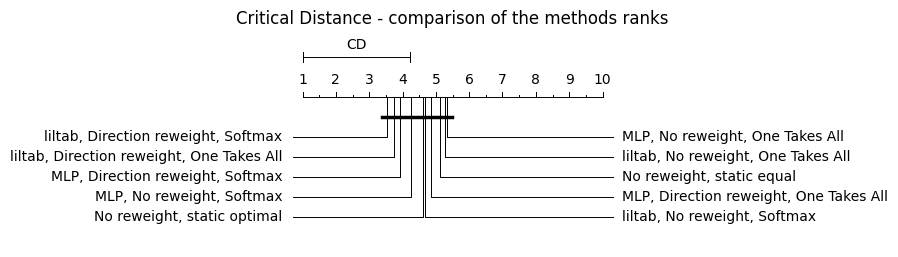

In [8]:
names = avg_ranks.index.tolist()
avranks =  avg_ranks.values.tolist()
datasets_n = np.unique(acc_b['data_name']).shape[0]
cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
print(cd)
scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)
plt.title('Critical Distance - comparison of the methods ranks')


# Gain comparison

In [9]:
comp = pd.merge(acc_b, baseline, on='data_name')
comp['diff'] = comp['score_x'] - comp['score_y']

names = np.unique(comp['experiment_name_x'].sort_values())
colors = []
for name in names:
    if 'static' in name:
        color = '#D4E09B'
    elif 'liltab' in name:
        color = '#A44A3F'
    else:
        color = '#F19C79'
    colors.append(color)

/tmp/ipykernel_44948/3928479946.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', palette=colors)


Text(0.5, 1.0, 'Test dataset\nGain in balanced accuracy, comparing to equal weights approach')

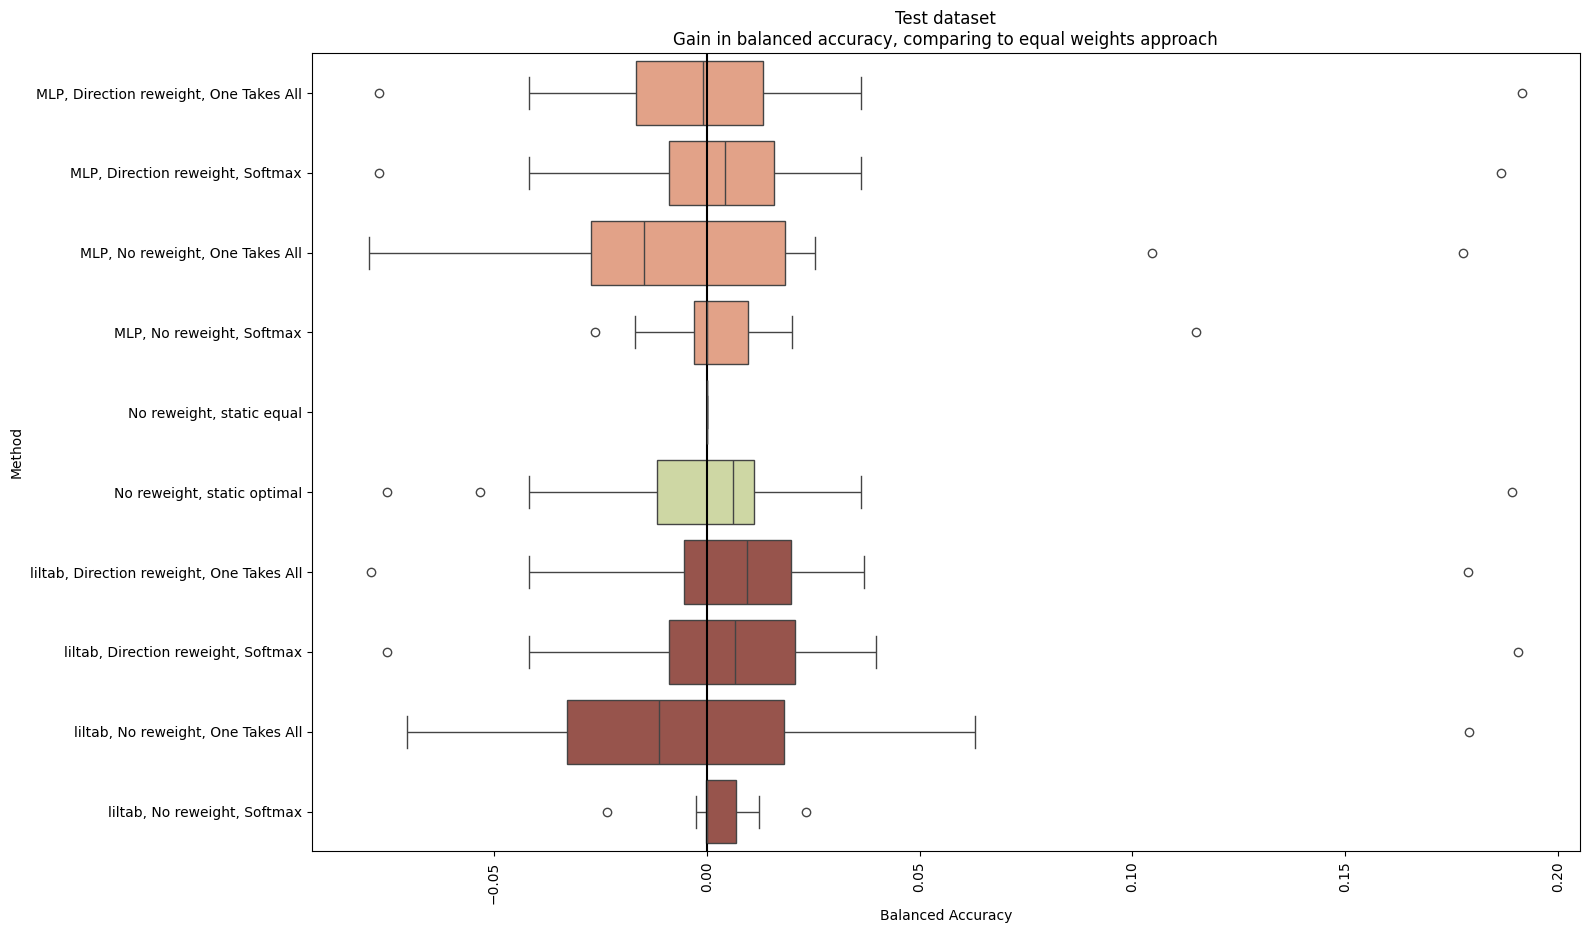

In [10]:
plt.figure(figsize=(16, 9))

sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', palette=colors)
plt.xticks(rotation=90)
plt.tight_layout()
plt.axvline(0, color='black')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Method')
plt.title('Test dataset\nGain in balanced accuracy, comparing to equal weights approach')


# Best method vs SoTA

In [11]:
comp = pd.merge(acc_b_best, baseline_sota, on='data_name')
comp['diff'] = comp['score_x'] - comp['score_y']

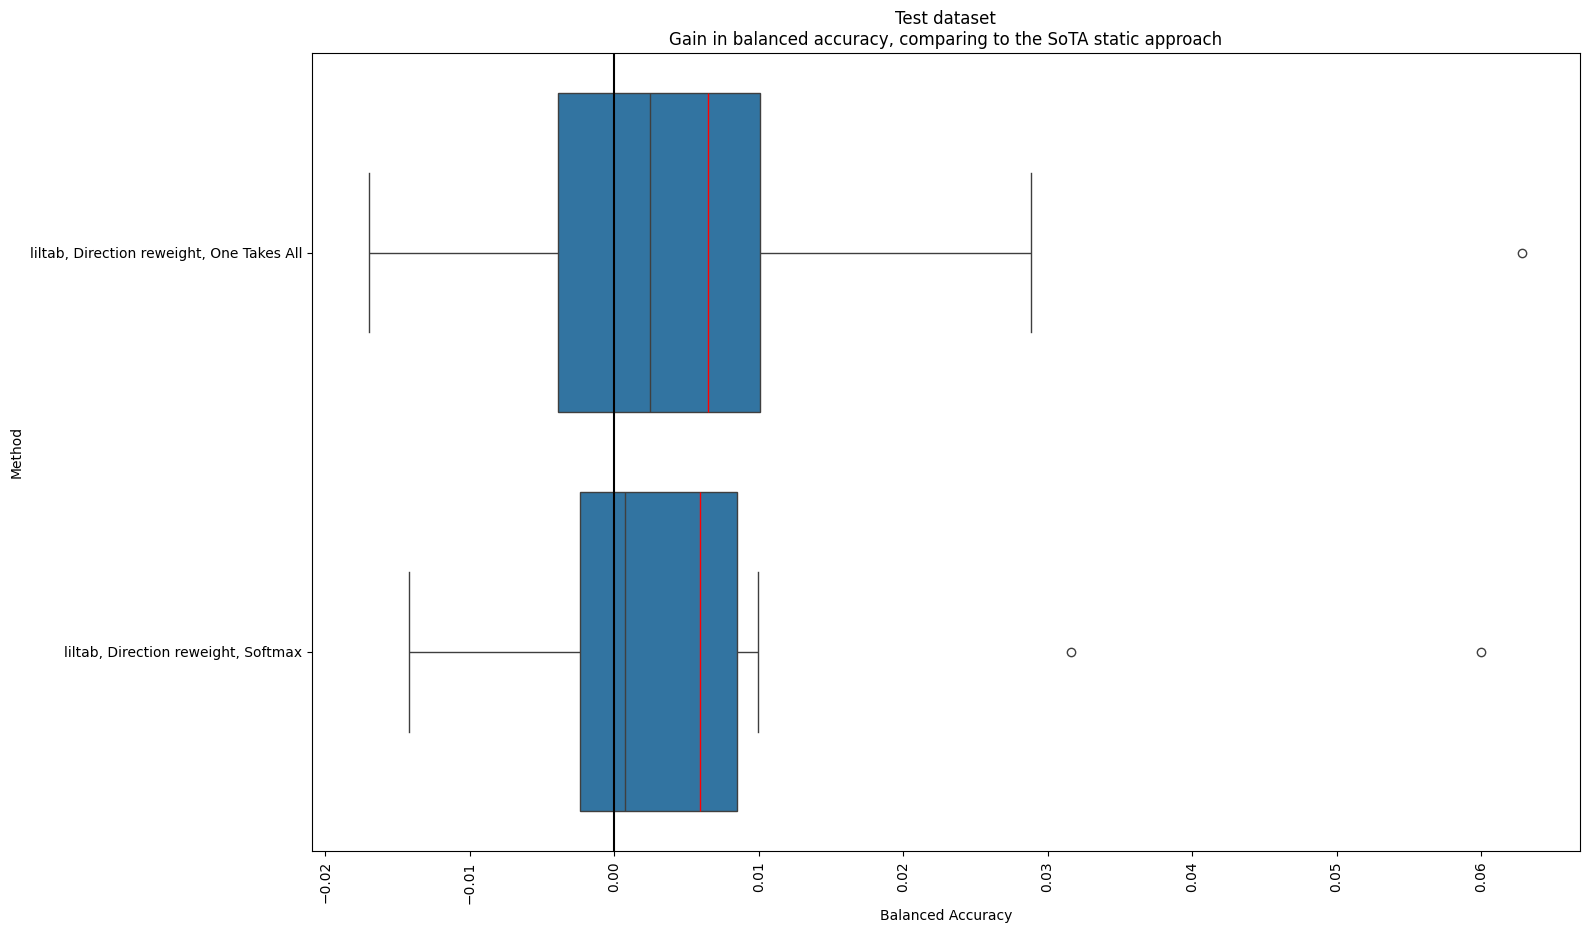

In [12]:
plt.figure(figsize=(16, 9))

g = sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', showmeans=True, meanline=True,)
plt.xticks(rotation=90)
plt.tight_layout()
plt.axvline(0, color='black')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Method')
plt.title('Test dataset\nGain in balanced accuracy, comparing to the SoTA static approach')

ax = plt.gca()
mean_lines = [line for line in ax.lines if line.get_linestyle() == '--']

for i in range(len(mean_lines)):
    mean_lines[i].set_color('red')
    mean_lines[i].set_linestyle('-')

plt.show()

# Weights diff norm

In [26]:
weights = report.get_weights_metrics()
weights = weights[weights['experiment_name'].isin(custom_solutions)]
weights['experiment_name'] = weights['experiment_name'].apply(change_exp_name)
weights = weights.sort_values('experiment_name')

In [25]:
names = np.unique(weights['experiment_name'].sort_values())
colors = []
for name in names:
    if 'static' in name:
        color = '#D4E09B'
    elif 'liltab' in name:
        color = '#A44A3F'
    else:
        color = '#F19C79'
    colors.append(color)

/tmp/ipykernel_44948/638242015.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=weights, x='norm', y='experiment_name', palette=colors)


<Axes: xlabel='norm', ylabel='experiment_name'>

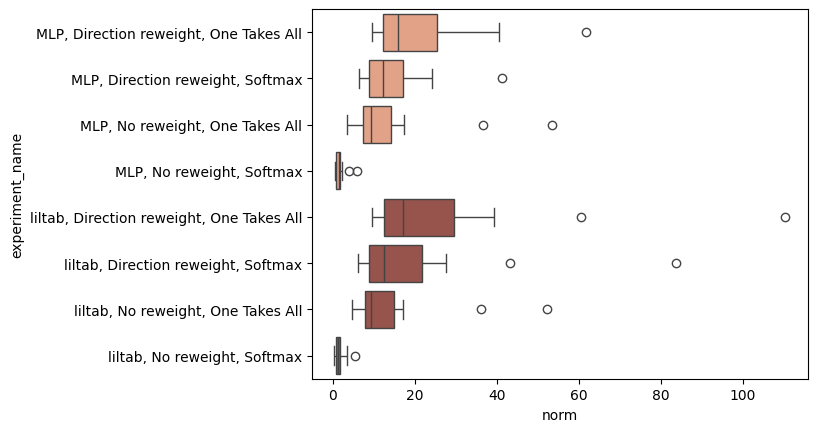

In [27]:
sns.boxplot(data=weights, x='norm', y='experiment_name', palette=colors)

/tmp/ipykernel_44948/1771934883.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=weights, x='std', y='experiment_name', palette=colors)


<Axes: xlabel='std', ylabel='experiment_name'>

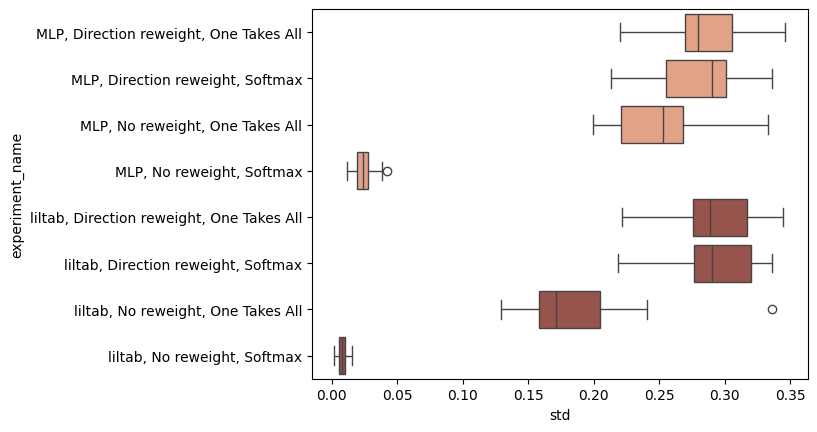

In [28]:
sns.boxplot(data=weights, x='std', y='experiment_name', palette=colors)